# Modulation Classification

Developing AutoML Model for AWGN Channel for Modulation Classification. SNR Ratio's(in dB) of Channel are $[5,10,15,20,25,30]$.

**Data Generation:**
Data is generated using MatLab's Communication Toolbox for Modulation Schemes QPSK, 16-QAM, 64-QAM for SNR Ratio's (in dB) $[5,10,15,20,25,30]$ when signal is transmitted through Channels AWGN and Rayleigh Channels.

**Modulation Classification:**
We will use AutoML to creae a classifer that predicts Modulation Scheme depending on In-Phase and Quadrature-Phase Components at the Receiver's End.

## Imports

### Importing Libraries

We will be using AutoKeras for generating AutoML Models.
Source of Documentation: [https://autokeras.com/](https://autokeras.com/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import seaborn as sns
import scipy.io
import os

# AutoML Libraries
!pip3 install autokeras
import autokeras as ak

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras.models import Model

     |████████████████████████████████| 174kB 19.7MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=c241329d9400cb20c8a532602a8d278e1907a8f8aaa842bf8c576ec89eb4c6de
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=5c7e2b4428e60f155723da5e7c91083e56351fe154c3d1f6c34ad7a5702c16ea
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


### Importing Data

Files are uploaded in Google Drive. Notebook is connected to Google Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Modulation-Classification/AutoML

Mounted at /gdrive
/gdrive/My Drive/Modulation-Classification/AutoML


## Processsing Data

Importing Data for all SNR Ratio's

In [3]:
def ImportData(Path):
    ModulationSchemes = os.listdir(Path)

    Dataset = {}
    for scheme in ModulationSchemes:
        DataPath = Path + "/" + scheme
        files = os.listdir(DataPath)
        DataofScheme = {}
        for f in files:
            Data = scipy.io.loadmat(DataPath + "/" + f)
            snr = Data['snr'][0][0]
            rx = Data['rx']
            InPhase, QuadPhase = rx.real, rx.imag
            DataofScheme[snr] = np.append(InPhase, QuadPhase, axis=1)
        Dataset[scheme] = DataofScheme

    return Dataset

## Train and Validation Datasets

**Training:**
- Received Signal with SNR Ratio $30$dB is used for Training for both Channels and all Modulation Schemes.

**Validation:**
- AutoML is validated on Received Signals with SNR Ratio's (in dB) $[5,10,15,20,25]$

In [4]:
def GenerateDatasets(Channel,L=None):
    if Channel == "AWGN":
        Path = "../Data/" + Channel
    elif Channel == "Rayleigh":
        Path = "../Data/" + Channel + "/" + str(L)
    Data = ImportData(Path)
    
    Dataset = {}
    Dataset['Classes'] = list(Data.keys())
    OneHotClasses = np.eye(len(Dataset['Classes']))

    Classes = {}
    for i in range(len(Dataset['Classes'])):
        Classes[Dataset['Classes'][i]] = OneHotClasses[i]

    Valid_SNRs = [5,10,15,20,25]

    if Channel == "AWGN":
        X_Train, y_Train = np.empty((0,2)), np.empty((0,3))
        X_Valid, y_Valid = {}, {}

        for snr in Valid_SNRs:
            X_Valid[snr] = np.empty((0,2))
            y_Valid[snr] = np.empty((0,3))


        for c in Classes.keys():
            ModData = Data[c]
            SNRs = ModData.keys()
            for snr in SNRs:
                if snr == 30:
                    X = ModData[snr]
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Train = np.append(X_Train,X,axis=0)
                    y_Train = np.append(y_Train,y,axis=0)
                else:
                    X = ModData[snr]
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Valid[snr] = np.append(X_Valid[snr], X, axis=0)
                    y_Valid[snr] = np.append(y_Valid[snr], y, axis=0)

    elif Channel == "Rayleigh":
        X_Train, y_Train = np.empty((0,100,2)), np.empty((0,3))
        X_Valid, y_Valid = {}, {}
        for snr in Valid_SNRs:
            X_Valid[snr] = np.empty((0,100,2))
            y_Valid[snr] = np.empty((0,3))

        for c in Classes.keys():
            ModData = Data[c]
            SNRs = ModData.keys()
            for snr in SNRs:
                if snr == 30:
                    X = ModData[snr]
                    X = X.reshape(-1,100,2)
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Train = np.append(X_Train,X,axis=0)
                    y_Train = np.append(y_Train,y,axis=0)
                else:
                    X = ModData[snr]
                    X = X.reshape(-1,100,2)
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Valid[snr] = np.append(X_Valid[snr], X, axis=0)
                    y_Valid[snr] = np.append(y_Valid[snr], y, axis=0)

    return X_Train, y_Train, X_Valid, y_Valid

## Evaluating Data

In [5]:
def EvaluateData(Model, X_Train, y_Train, X_Valid, y_Valid, Name, ValidBatchSize=32):
    Valid_SNR = np.array([5,10,15,20,25,30])
    Accuracy = []

    print ("Evaluating Model")
    for snr in Valid_SNR:
        if snr == 30:
            Loss, Acc = Model.evaluate(X_Train, y_Train)
        else:
            Loss, Acc = Model.evaluate(X_Valid[snr], y_Valid[snr], batch_size=ValidBatchSize)
        print ("SNR:", snr, "Accuracy:", Acc)
        Accuracy.append(Acc)

    Accuracy = np.array(Accuracy)

    plt.figure(figsize=(10,10))
    plt.plot(Valid_SNR,Accuracy, color='blue')
    plt.scatter(Valid_SNR,Accuracy, color='red')
    plt.title("Accuracy vs SNR")
    plt.xlabel("SNR")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.savefig("Images/" + Name)
    plt.show()

## AutoML Model for AWGN Channel

For AWGN Channel, Input Dimensions is $(2,)$

#### AWGN Data

In [6]:
X_Train, y_Train, X_Valid, y_Valid = GenerateDatasets('AWGN')

#### Creating a Classifier

In [7]:
AWGNClassifier = ak.StructuredDataClassifier(
    overwrite=True,
    max_trials=10,
    loss='categorical_crossentropy',
    num_classes=3)

AWGNClassifier.fit(X_Train, y_Train, epochs=15, batch_size=64, validation_split=0.1)

Trial 10 Complete [00h 00m 25s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 02m 49s
INFO:tensorflow:Oracle triggered exit
Epoch 1/15
469/469 [==============================] - 1s 2ms/step - loss: 0.7811 - accuracy: 0.8016
Epoch 2/15
469/469 [==============================] - 1s 2ms/step - loss: 1.2365 - accuracy: 0.5278
Epoch 3/15
469/469 [==============================] - 1s 2ms/step - loss: 0.9284 - accuracy: 0.6104
Epoch 4/15
469/469 [==============================] - 1s 2ms/step - loss: 0.8825 - accuracy: 0.6316
Epoch 5/15
469/469 [==============================] - 1s 2ms/step - loss: 0.8720 - accuracy: 0.6172
Epoch 6/15
469/469 [==============================] - 1s 2ms/step - loss: 0.8647 - accuracy: 0.6098
Epoch 7/15
469/469 [==============================] - 1s 2ms/step - loss: 0.8093 - accuracy: 0.6211
Epoch 8/15
469/469 [==============================] - 1s 2ms/step - loss: 0.7818 - accuracy: 0.6309
Epoch 9/15
469/469 [=============================

#### Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 2)                 0         
_________________________________________________________________
normalization (Normalization (None, 2)                 5         
_________________________________________________________________
dense (Dense)                (None, 32)                96        
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

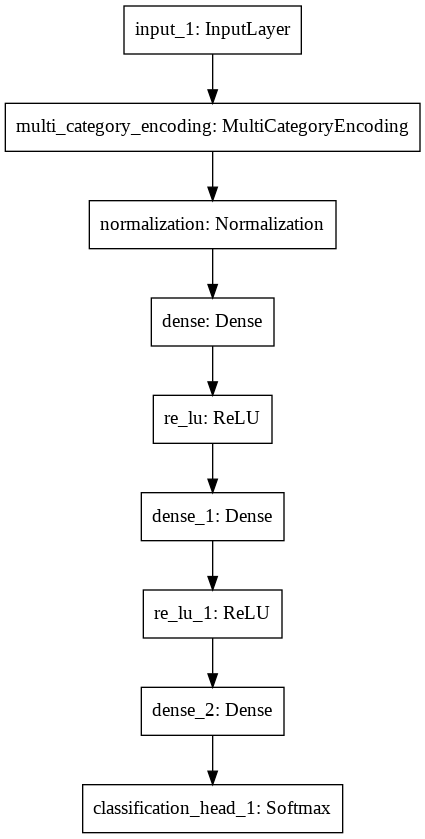

In [8]:
AWGN_Model = AWGNClassifier.export_model()
AWGN_Model.summary()
tf.keras.utils.plot_model(AWGN_Model, to_file='Images/AWGN_Model.png', show_shapes=False,show_layer_names=True)

### Training and Evaluating Model

#### Training the Model

In [9]:
AWGN_Model.fit(X_Train, y_Train, epochs=20, batch_size=4, validation_split=0.1,shuffle=True)

Epoch 1/20
6750/6750 [==============================] - 14s 2ms/step - loss: 0.2506 - accuracy: 0.9232 - val_loss: 0.6554 - val_accuracy: 0.7497
Epoch 2/20
6750/6750 [==============================] - 13s 2ms/step - loss: 0.1952 - accuracy: 0.9354 - val_loss: 0.4793 - val_accuracy: 0.7503
Epoch 3/20
6750/6750 [==============================] - 13s 2ms/step - loss: 0.1911 - accuracy: 0.9356 - val_loss: 0.5049 - val_accuracy: 0.7497
Epoch 4/20
6750/6750 [==============================] - 13s 2ms/step - loss: 0.1901 - accuracy: 0.9356 - val_loss: 0.5130 - val_accuracy: 0.7500
Epoch 5/20
6750/6750 [==============================] - 13s 2ms/step - loss: 0.1880 - accuracy: 0.9353 - val_loss: 0.5757 - val_accuracy: 0.7500
Epoch 6/20
6750/6750 [==============================] - 13s 2ms/step - loss: 0.1870 - accuracy: 0.9356 - val_loss: 0.4633 - val_accuracy: 0.7560
Epoch 7/20
6750/6750 [==============================] - 13s 2ms/step - loss: 0.1862 - accuracy: 0.9356 - val_loss: 0.4826 - val_ac

#### Evaluate the Model

Evaluating Model
938/938 [==============================] - 2s 2ms/step - loss: 3.3829 - accuracy: 0.6325
SNR: 5 Accuracy: 0.6324999928474426
938/938 [==============================] - 2s 2ms/step - loss: 1.7095 - accuracy: 0.7042
SNR: 10 Accuracy: 0.7042333483695984
938/938 [==============================] - 2s 2ms/step - loss: 0.7793 - accuracy: 0.7886
SNR: 15 Accuracy: 0.7886333465576172
938/938 [==============================] - 2s 2ms/step - loss: 0.3459 - accuracy: 0.8770
SNR: 20 Accuracy: 0.876966655254364
938/938 [==============================] - 2s 2ms/step - loss: 0.2221 - accuracy: 0.9171
SNR: 25 Accuracy: 0.9170666933059692
938/938 [==============================] - 2s 2ms/step - loss: 0.2045 - accuracy: 0.9215
SNR: 30 Accuracy: 0.9214666485786438


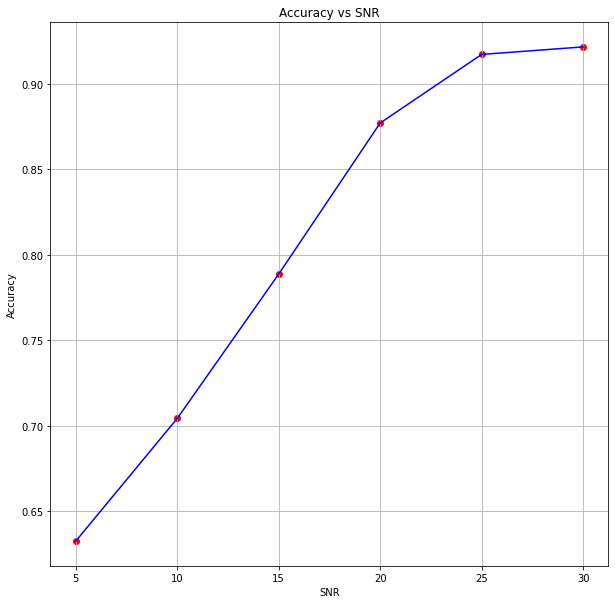

In [10]:
EvaluateData(AWGN_Model, X_Train, y_Train, X_Valid, y_Valid, "AWGN_Accuracy.jpg")

#### Save Model

In [11]:
AWGN_Model.save("Model/AWGN.h5")

## AutoML Model for Rayleigh Channel of Channel-Length = 2

For Rayleigh Channel, Input Dimensions is (100,2)

#### Rayleigh Data

In [12]:
X_Train, y_Train, X_Valid, y_Valid = GenerateDatasets('Rayleigh',L=2)

#### Creating a CNN Classifier

In [13]:
RayleighClassifier = ak.ImageClassifier(
    overwrite=True,
    max_trials=1,
    loss='categorical_crossentropy',
    num_classes=3)

RayleighClassifier.fit(X_Train, y_Train, epochs=5, batch_size=16, validation_split=0.1)

Trial 1 Complete [00h 00m 44s]
val_loss: 9.936233254848048e-05

Best val_loss So Far: 9.936233254848048e-05
Total elapsed time: 00h 00m 44s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1452 - accuracy: 0.9717
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3186 - accuracy: 0.8704
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.5202 - accuracy: 0.9125
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.4413 - accuracy: 0.9022
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3017 - accuracy: 0.9137
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


#### CNN Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 100, 2, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 100, 2, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 2, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 2, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 1, 64)         0     

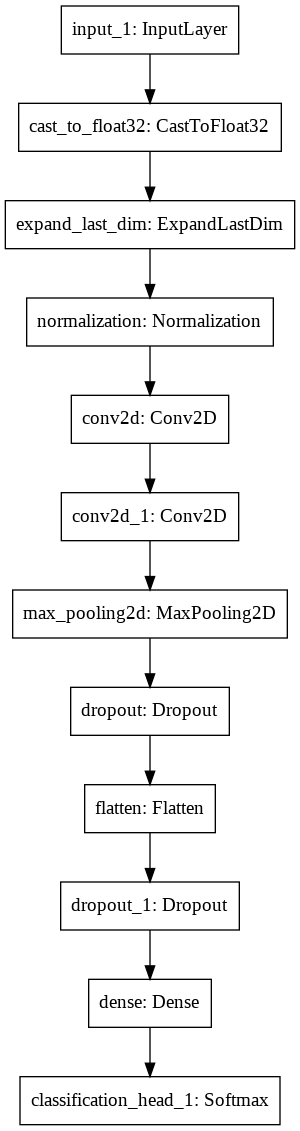

In [14]:
Rayleigh_Model = RayleighClassifier.export_model()
Rayleigh_Model.summary()
tf.keras.utils.plot_model(Rayleigh_Model, to_file='Images/Rayleigh_Model_L=2.png', show_shapes=False,show_layer_names=True)

### Training and Evaluating CNN Model

#### Training the CNN Model

In [15]:
Rayleigh_Model.fit(X_Train, y_Train, epochs=20, batch_size=16, validation_split=0.3,shuffle=True)

Epoch 1/20
657/657 [==============================] - 3s 4ms/step - loss: 0.1222 - accuracy: 0.9575 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 2/20
657/657 [==============================] - 2s 4ms/step - loss: 0.0016 - accuracy: 0.9999 - val_loss: 2.8590e-04 - val_accuracy: 1.0000
Epoch 3/20
657/657 [==============================] - 2s 4ms/step - loss: 0.0014 - accuracy: 0.9994 - val_loss: 8.1765e-05 - val_accuracy: 1.0000
Epoch 4/20
657/657 [==============================] - 2s 4ms/step - loss: 0.0015 - accuracy: 0.9994 - val_loss: 5.0742e-05 - val_accuracy: 1.0000
Epoch 5/20
657/657 [==============================] - 2s 4ms/step - loss: 4.9049e-04 - accuracy: 0.9999 - val_loss: 2.6413e-05 - val_accuracy: 1.0000
Epoch 6/20
657/657 [==============================] - 3s 4ms/step - loss: 9.1821e-05 - accuracy: 1.0000 - val_loss: 1.5758e-05 - val_accuracy: 1.0000
Epoch 7/20
657/657 [==============================] - 2s 4ms/step - loss: 0.0041 - accuracy: 0.9986 - val_loss: 3.8305e-

#### Evaluate the CNN Model

Evaluating Model
469/469 [==============================] - 1s 2ms/step - loss: 31.9319 - accuracy: 0.4243
SNR: 5 Accuracy: 0.42426666617393494
469/469 [==============================] - 1s 2ms/step - loss: 19.8008 - accuracy: 0.6667
SNR: 10 Accuracy: 0.6666666865348816
469/469 [==============================] - 1s 2ms/step - loss: 0.0016 - accuracy: 0.9997
SNR: 15 Accuracy: 0.999666690826416
469/469 [==============================] - 1s 2ms/step - loss: 0.5898 - accuracy: 0.9055
SNR: 20 Accuracy: 0.9054666757583618
469/469 [==============================] - 1s 2ms/step - loss: 7.1891 - accuracy: 0.6703
SNR: 25 Accuracy: 0.6702666878700256
469/469 [==============================] - 1s 2ms/step - loss: 5.9915e-07 - accuracy: 1.0000
SNR: 30 Accuracy: 1.0


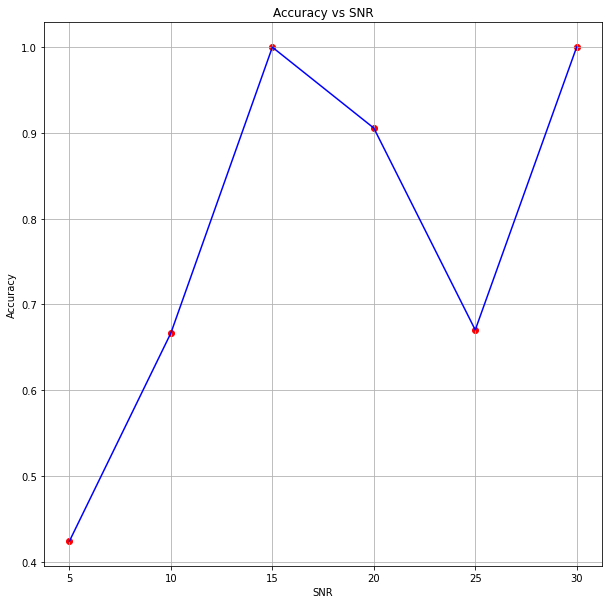

In [16]:
EvaluateData(Rayleigh_Model, X_Train, y_Train, X_Valid, y_Valid, "Rayleigh_Accuracy_L=2.jpg")

#### Save CNN Model

In [17]:
Rayleigh_Model.save("Model/Rayleigh_L=2.h5")

## AutoML Model for Rayleigh Channel of Channel-Length = 3

For Rayleigh Channel, Input Dimensions is (100,2)

#### Rayleigh Data

In [18]:
X_Train, y_Train, X_Valid, y_Valid = GenerateDatasets('Rayleigh',L=3)

#### Creating a CNN Classifier

In [19]:
RayleighClassifier = ak.ImageClassifier(
    overwrite=True,
    max_trials=1,
    loss='categorical_crossentropy',
    num_classes=3)

RayleighClassifier.fit(X_Train, y_Train, epochs=5, batch_size=16, validation_split=0.1)

Trial 1 Complete [00h 00m 15s]
val_loss: 0.00016301537107210606

Best val_loss So Far: 0.00016301537107210606
Total elapsed time: 00h 00m 15s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 0.2247 - accuracy: 0.9771
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.7225 - accuracy: 0.7739
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.4601 - accuracy: 0.8744
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.2652 - accuracy: 0.9240
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1144 - accuracy: 0.9784
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


#### CNN Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 100, 2, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 100, 2, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 2, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 2, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 1, 64)         0     

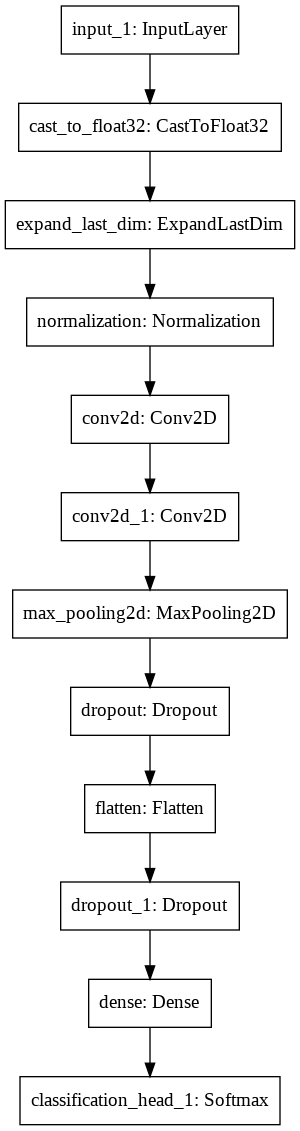

In [20]:
Rayleigh_Model = RayleighClassifier.export_model()
Rayleigh_Model.summary()
tf.keras.utils.plot_model(Rayleigh_Model, to_file='Images/Rayleigh_Model_L=3.png', show_shapes=False,show_layer_names=True)

### Training and Evaluating CNN Model

#### Training the CNN Model

In [21]:
Rayleigh_Model.fit(X_Train, y_Train, epochs=20, batch_size=16, validation_split=0.3,shuffle=True)

Epoch 1/20
657/657 [==============================] - 3s 4ms/step - loss: 0.0563 - accuracy: 0.9824 - val_loss: 1.7538e-05 - val_accuracy: 1.0000
Epoch 2/20
657/657 [==============================] - 2s 4ms/step - loss: 1.6757e-05 - accuracy: 1.0000 - val_loss: 1.8036e-06 - val_accuracy: 1.0000
Epoch 3/20
657/657 [==============================] - 2s 4ms/step - loss: 5.1829e-06 - accuracy: 1.0000 - val_loss: 8.6064e-07 - val_accuracy: 1.0000
Epoch 4/20
657/657 [==============================] - 2s 4ms/step - loss: 2.2064e-06 - accuracy: 1.0000 - val_loss: 1.9277e-07 - val_accuracy: 1.0000
Epoch 5/20
657/657 [==============================] - 2s 4ms/step - loss: 1.0219e-06 - accuracy: 1.0000 - val_loss: 1.7216e-07 - val_accuracy: 1.0000
Epoch 6/20
657/657 [==============================] - 2s 4ms/step - loss: 1.0010e-06 - accuracy: 1.0000 - val_loss: 1.4167e-07 - val_accuracy: 1.0000
Epoch 7/20
657/657 [==============================] - 2s 4ms/step - loss: 3.2890e-07 - accuracy: 1.0000 

#### Evaluate the CNN Model

Evaluating Model
469/469 [==============================] - 1s 2ms/step - loss: 30.9469 - accuracy: 0.5671
SNR: 5 Accuracy: 0.5671333074569702
469/469 [==============================] - 1s 2ms/step - loss: 10.2476 - accuracy: 0.6611
SNR: 10 Accuracy: 0.6610666513442993
469/469 [==============================] - 1s 2ms/step - loss: 8.6266 - accuracy: 0.7249
SNR: 15 Accuracy: 0.7248666882514954
469/469 [==============================] - 1s 2ms/step - loss: 0.0131 - accuracy: 0.9952
SNR: 20 Accuracy: 0.995199978351593
469/469 [==============================] - 1s 2ms/step - loss: 6.9453 - accuracy: 0.6282
SNR: 25 Accuracy: 0.6281999945640564
469/469 [==============================] - 1s 2ms/step - loss: 6.3578e-11 - accuracy: 1.0000
SNR: 30 Accuracy: 1.0


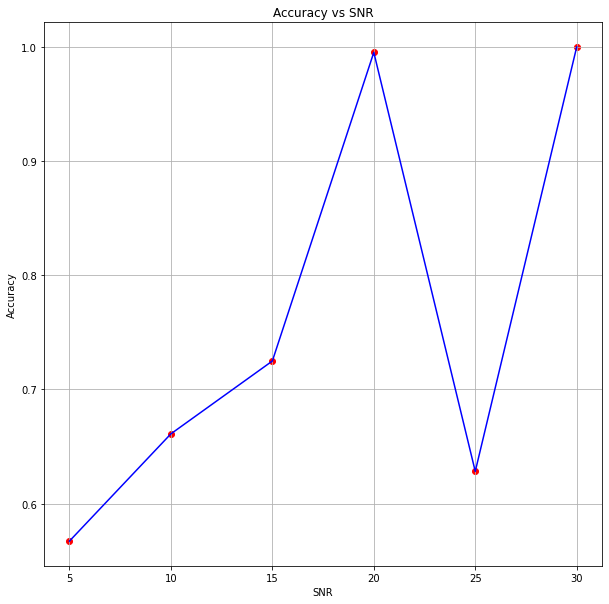

In [22]:
EvaluateData(Rayleigh_Model, X_Train, y_Train, X_Valid, y_Valid, "Rayleigh_Accuracy_L=3.jpg")

#### Save CNN Model

In [23]:
Rayleigh_Model.save("Model/Rayleigh_L=3.h5")

## CNN Model for Rayleigh Data

In [24]:
def CreateCNNModel():
    tf.keras.backend.clear_session()
    In = Input(shape=(100,2,1))
    x = Conv2D(filters=64,kernel_size=(3,1),activation='relu')(In)
    x = Conv2D(filters=16,kernel_size=(3,2),activation='relu')(x)
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x)
    Ou = Dense(3,activation='softmax')(x)

    model = Model(In,Ou)
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["acc"])

    return model

### Rayleigh Fading of Channel Length = 2

Data Generation

In [25]:
X_Train, y_Train, X_Valid, y_Valid = GenerateDatasets('Rayleigh',L=2)
X_Train = np.expand_dims(X_Train,axis=-1)
for snr in [5,10,15,20,25]:
    X_Valid[snr] = np.expand_dims(X_Valid[snr],axis=-1)

Model Creation

In [26]:
CNNModel2 = CreateCNNModel()
CNNModel2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 2, 64)         256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 1, 16)         6160      
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 203,539
Trainable params: 203,539
Non-trainable params: 0
_______________________________________________________

Training

In [27]:
CNNModel2.fit(X_Train, y_Train, epochs=20, batch_size=16, validation_split=0.3,shuffle=True)

Epoch 1/20
657/657 [==============================] - 3s 4ms/step - loss: 0.2403 - acc: 0.8750 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 2/20
657/657 [==============================] - 2s 3ms/step - loss: 6.0416e-04 - acc: 1.0000 - val_loss: 3.6501e-04 - val_acc: 1.0000
Epoch 3/20
657/657 [==============================] - 2s 4ms/step - loss: 4.2214e-05 - acc: 1.0000 - val_loss: 1.1728e-04 - val_acc: 1.0000
Epoch 4/20
657/657 [==============================] - 2s 4ms/step - loss: 2.0126e-05 - acc: 1.0000 - val_loss: 5.6324e-05 - val_acc: 1.0000
Epoch 5/20
657/657 [==============================] - 2s 4ms/step - loss: 1.0232e-05 - acc: 1.0000 - val_loss: 3.2205e-05 - val_acc: 1.0000
Epoch 6/20
657/657 [==============================] - 2s 4ms/step - loss: 6.5537e-06 - acc: 1.0000 - val_loss: 1.9419e-05 - val_acc: 1.0000
Epoch 7/20
657/657 [==============================] - 2s 4ms/step - loss: 4.5615e-06 - acc: 1.0000 - val_loss: 1.2228e-05 - val_acc: 1.0000
Epoch 8/20
657/657 [========

Evaluating

Evaluating Model
469/469 [==============================] - 1s 2ms/step - loss: 18.6687 - acc: 0.3704
SNR: 5 Accuracy: 0.37040001153945923
469/469 [==============================] - 1s 2ms/step - loss: 12.8557 - acc: 0.6667
SNR: 10 Accuracy: 0.6666666865348816
469/469 [==============================] - 1s 2ms/step - loss: 0.0362 - acc: 0.9927
SNR: 15 Accuracy: 0.992733359336853
469/469 [==============================] - 1s 2ms/step - loss: 0.4944 - acc: 0.8935
SNR: 20 Accuracy: 0.8934666514396667
469/469 [==============================] - 1s 2ms/step - loss: 7.2860 - acc: 0.4790
SNR: 25 Accuracy: 0.4790000021457672
469/469 [==============================] - 1s 2ms/step - loss: 5.4455e-08 - acc: 1.0000
SNR: 30 Accuracy: 1.0


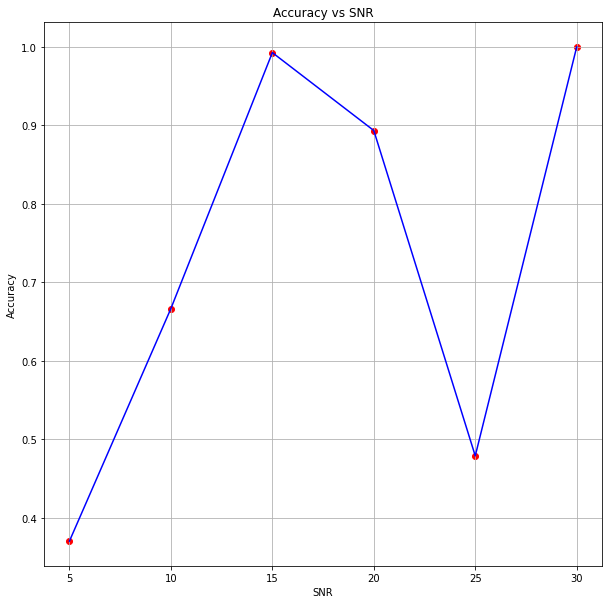

In [28]:
EvaluateData(CNNModel2, X_Train, y_Train, X_Valid, y_Valid, "CNN_Rayleigh_Accuracy_L=2.jpg")

### Rayleigh Fading of Channel Length = 3

Data Generation

In [29]:
X_Train, y_Train, X_Valid, y_Valid = GenerateDatasets('Rayleigh',L=3)
X_Train = np.expand_dims(X_Train,axis=-1)
for snr in [5,10,15,20,25]:
    X_Valid[snr] = np.expand_dims(X_Valid[snr],axis=-1)

Model Creation

In [30]:
CNNModel3 = CreateCNNModel()
CNNModel3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 2, 64)         256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 1, 16)         6160      
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 203,539
Trainable params: 203,539
Non-trainable params: 0
_______________________________________________________

Training

In [31]:
CNNModel3.fit(X_Train, y_Train, epochs=20, batch_size=16, validation_split=0.3,shuffle=True)

Epoch 1/20
657/657 [==============================] - 3s 4ms/step - loss: 0.1886 - acc: 0.9153 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 2/20
657/657 [==============================] - 3s 4ms/step - loss: 7.6084e-05 - acc: 1.0000 - val_loss: 3.1688e-04 - val_acc: 1.0000
Epoch 3/20
657/657 [==============================] - 2s 4ms/step - loss: 2.3397e-05 - acc: 1.0000 - val_loss: 1.6271e-04 - val_acc: 1.0000
Epoch 4/20
657/657 [==============================] - 2s 4ms/step - loss: 1.1223e-05 - acc: 1.0000 - val_loss: 7.9153e-05 - val_acc: 1.0000
Epoch 5/20
657/657 [==============================] - 2s 4ms/step - loss: 5.7265e-06 - acc: 1.0000 - val_loss: 5.3454e-05 - val_acc: 1.0000
Epoch 6/20
657/657 [==============================] - 2s 4ms/step - loss: 3.3754e-06 - acc: 1.0000 - val_loss: 2.8181e-05 - val_acc: 1.0000
Epoch 7/20
657/657 [==============================] - 2s 4ms/step - loss: 2.2408e-06 - acc: 1.0000 - val_loss: 2.2181e-05 - val_acc: 1.0000
Epoch 8/20
657/657 [========

Evaluating

Evaluating Model
469/469 [==============================] - 1s 2ms/step - loss: 27.8227 - acc: 0.6624
SNR: 5 Accuracy: 0.6624000072479248
469/469 [==============================] - 1s 2ms/step - loss: 17.0923 - acc: 0.3781
SNR: 10 Accuracy: 0.37806665897369385
469/469 [==============================] - 1s 2ms/step - loss: 27.1486 - acc: 0.5464
SNR: 15 Accuracy: 0.5464000105857849
469/469 [==============================] - 1s 2ms/step - loss: 1.5172 - acc: 0.6599
SNR: 20 Accuracy: 0.65993332862854
469/469 [==============================] - 1s 2ms/step - loss: 11.7893 - acc: 0.3454
SNR: 25 Accuracy: 0.34540000557899475
469/469 [==============================] - 1s 2ms/step - loss: 8.3367e-08 - acc: 1.0000
SNR: 30 Accuracy: 1.0


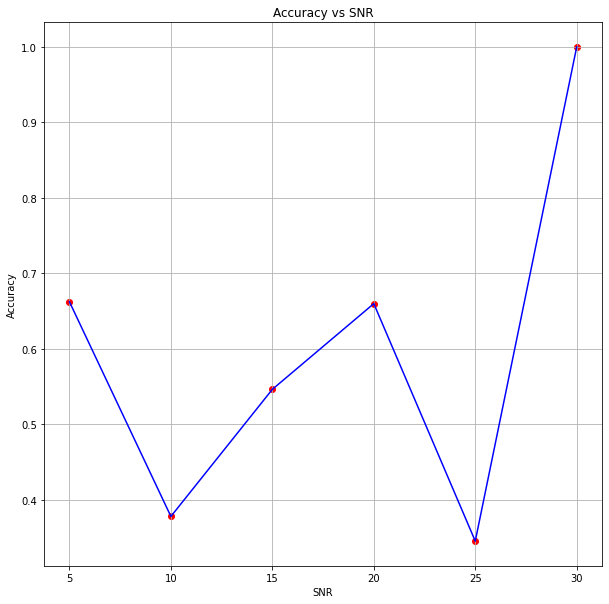

In [32]:
EvaluateData(CNNModel3, X_Train, y_Train, X_Valid, y_Valid, "CNN_Rayleigh_Accuracy_L=3.jpg")